In [57]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


In [58]:
# Define dataset paths
train_path = './CNN_dataset/train'
test_path = './CNN_dataset/test'


In [64]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load data with flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Ensure class names are consistent between train and test
assert train_generator.class_indices == test_generator.class_indices, \
    "Mismatch in class names between train and test datasets."

# Class labels
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")


Found 50000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.
Classes: ['AbdomenCT', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


In [65]:
# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer matches the number of classes
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [66]:
# Train the model
epochs = 1
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 419s 268ms/step - accuracy: 0.8236 - loss: 0.4492 - val_accuracy: 0.9933 - val_loss: 0.0231


In [67]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9933 - loss: 0.0233
Test Loss: 0.0231, Test Accuracy: 0.9933


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step


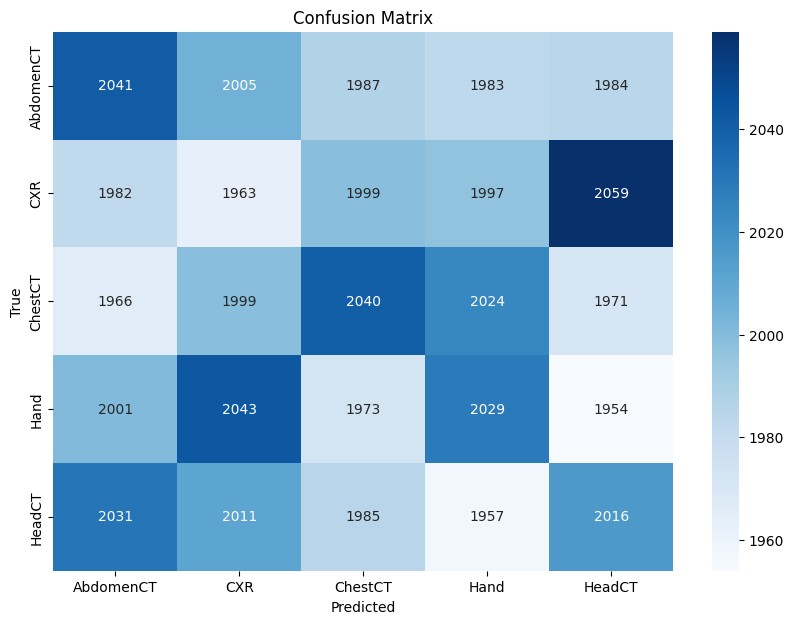

In [68]:
# Reset test generator
test_generator.reset()

# Get true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [69]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       0.20      0.20      0.20     10000
         CXR       0.20      0.20      0.20     10000
     ChestCT       0.20      0.20      0.20     10000
        Hand       0.20      0.20      0.20     10000
      HeadCT       0.20      0.20      0.20     10000

    accuracy                           0.20     50000
   macro avg       0.20      0.20      0.20     50000
weighted avg       0.20      0.20      0.20     50000



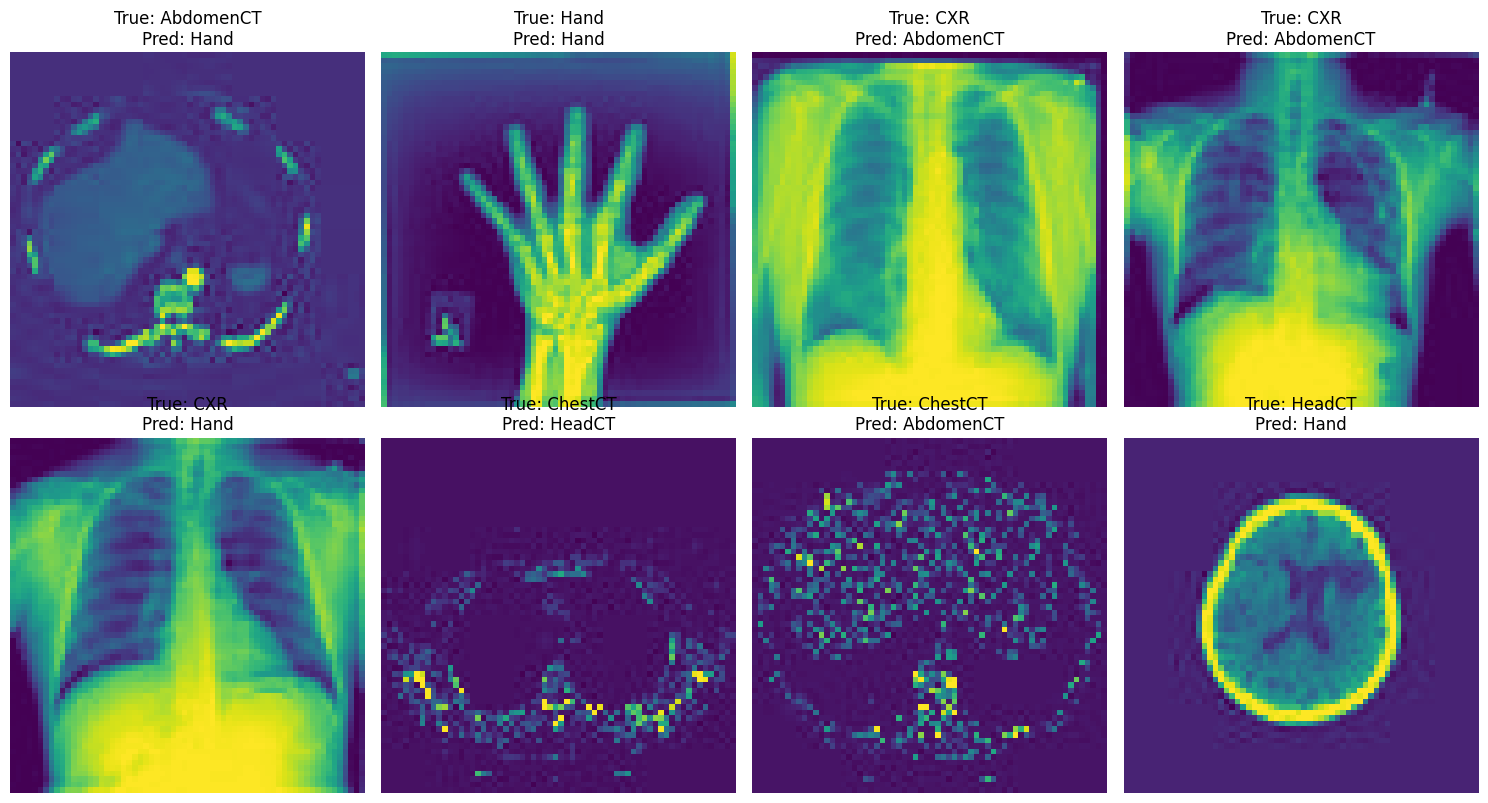

In [70]:
# Visualize random predictions
import random

# Select random indices
random_indices = random.sample(range(len(test_generator.filenames)), 8)
sample_files = [test_generator.filepaths[i] for i in random_indices]
sample_images = [plt.imread(f) for f in sample_files]
sample_labels = [y_true[i] for i in random_indices]
sample_preds = [y_pred_classes[i] for i in random_indices]

# Plot samples
plt.figure(figsize=(15, 8))
for i, (img, true_label, pred_label) in enumerate(zip(sample_images, sample_labels, sample_preds)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [72]:
# Save the model
model.save("cnn_model_tf_fixed.keras")
print("Model saved successfully!")


Model saved successfully!
